In [1]:
import arcpy
import os, sys
from arcgis.gis import GIS
from arcgis import features
from getpass import getpass #to accept passwords in an interactive fashion
from getpass import getuser
from IPython.display import display

In [2]:
# Set the default path to ArcGIS Pro projects
prjPath = (os.environ['USERPROFILE']+'\Documents\ArcGIS\Projects\\')
#print(prjPath)

In [3]:
changePath = input('Default ArcGIS Project Path: {}, change path? [Y or N]'.format(prjPath))
if changePath.upper() in "YES":
    prjPath = input("Enter new path ")
    os.chdir(prjPath)
for project in os.listdir(prjPath):
    usePrj = input("Use project {} [Y or N]".format(project))
    if usePrj.upper() in "YES":
        prjPath = os.path.join(prjPath,project)
        break
for root, dirs, files in os.walk(prjPath):
    for file in files:
        if file.endswith(".aprx"):
            aprx = os.path.join(root, file)
            display(aprx)

Default ArcGIS Project Path: C:\Users\friendde\Documents\ArcGIS\Projects\, change path? [Y or N]n
Use project AlpineAuditProduction [Y or N]n
Use project CountyLights [Y or N]n
Use project LED Change Out [Y or N]y


'C:\\Users\\friendde\\Documents\\ArcGIS\\Projects\\LED Change Out\\LED Change Out.aprx'

In [4]:
response = input("Do you want to use the active portal - {} [Y or N]".format(arcpy.GetActivePortalURL()))
if response.upper() in "YES":
    portal = arcpy.GetActivePortalURL()
else:
    portal = input("Enter portal address")

display(portal)
#portal = 'https://www.arcgis.com' # Can also reference a local portal
user = input("enter username")
#print(getuser())
password = getpass()
print('Connecting to {}'.format(portal))
gis = GIS(portal, user, password)

Do you want to use the active portal - https://gru.maps.arcgis.com/ [Y or N]y


'https://gru.maps.arcgis.com/'

enter usernamearcgiswebservices
········
Connecting to https://gru.maps.arcgis.com/


<Item title:"AerialCable" type:Feature Layer Collection owner:arcgiswebservices>
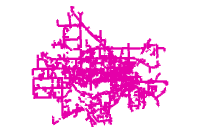

Update AerialCable [Y,N]n


<Item title:"CountyLightsHPS" type:Feature Layer Collection owner:arcgiswebservices>
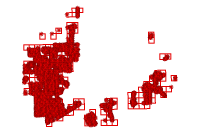

Update CountyLightsHPS [Y,N]n


<Item title:"CW_BaseMap" type:Feature Layer Collection owner:arcgiswebservices>
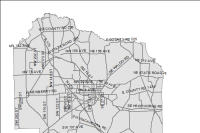

Update CW_BaseMap [Y,N]n


<Item title:"ElectricDamageAssessmentPie" type:Feature Layer Collection owner:arcgiswebservices>
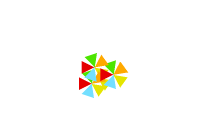

Update ElectricDamageAssessmentPie [Y,N]n


<Item title:"FieldCheckPoles" type:Feature Layer Collection owner:arcgiswebservices>
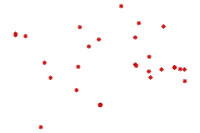

Update FieldCheckPoles [Y,N]n


<Item title:"GRUBaseMap" type:Feature Layer Collection owner:arcgiswebservices>
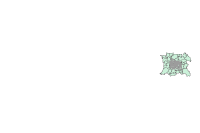

Update GRUBaseMap [Y,N]n


<Item title:"GRUComFiber" type:Feature Layer Collection owner:arcgiswebservices>
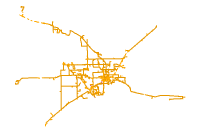

Update GRUComFiber [Y,N]n


<Item title:"Lights" type:Feature Layer Collection owner:arcgiswebservices>
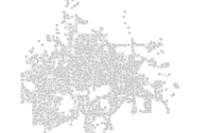

Update Lights [Y,N]y
Lights
<Item title:"Lights" type:Service Definition owner:arcgiswebservices>


In [5]:
# search and list all items owned by connected user
query="owner:{}".format(user)
item_type="Feature Layer"
sort_field="title"
sort_order="asc"
max_items=100
search_result = gis.content.search(query,item_type,sort_field,sort_order,max_items)
for i in range(len(search_result)):
    display(search_result[i])
    updateResult = input("Update {} [Y,N]".format(search_result[i].title))
    if updateResult.upper() in "YES":
        sd_fs_name = search_result[i].title
        print(sd_fs_name)
        query = "owner:{} AND title:{}".format(user,sd_fs_name)
        sdItem = gis.content.search(query,item_type="Service Definition")[0]
        print(sdItem)
        break

In [6]:
# Set sharing options
shrOrg = True
shrEveryone = False
shrGroups = ""
# Local paths to create temporary content
#relPath = sys.path[0]
sddraft = os.path.join(prjPath, "{}.sddraft".format(sdItem.title))
print(sddraft)
sd = os.path.join(prjPath, "{}.sd".format(sdItem.title))
print(sd)

C:\Users\friendde\Documents\ArcGIS\Projects\LED Change Out\Lights.sddraft
C:\Users\friendde\Documents\ArcGIS\Projects\LED Change Out\Lights.sd


In [10]:
arcpy.env.overwriteOutput = True
prjMap = arcpy.mp.ArcGISProject(aprx)
m = prjMap.listMaps()[0]
display(m)

In [12]:
#m = aprx.listMaps("World")[0]
# Create FeatureSharingDraft and set service properties
sharing_draft = m.getWebLayerSharingDraft("HOSTING_SERVER", "FEATURE", sdItem.title)
#sharing_draft.summary = "My Summary"
#sharing_draft.tags = "My Tags"
#sharing_draft.description = "My Description"
#sharing_draft.credits = "My Credits"
#sharing_draft.useLimitations = "My Use Limitations"
sharing_draft.overwriteExistingService = True

# Create Service Defintion Draft file
sharing_draft.exportToSDDraft(sddraft)

# Stage Service
#sd_filename = service + ".sd"
#sd_output_filename = os.path.join(outdir, sd)
arcpy.StageService_server(sddraft, sd)

# Share to portal
print("Uploading Service Definition...")
arcpy.UploadServiceDefinition_server(sd, "My Hosted Services")

print("Successfully Uploaded service.")

Uploading Service Definition...


ExecuteError: ERROR 001398: Service name 'Lights' already exists.
Failed to execute (UploadServiceDefinition).
